In [1]:
#导入相关包
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
#获取训练集全部图片
train_img = glob.glob("./dataset/split_train/train/images/*.png") 

In [3]:
train_count = len(train_img)
train_img[:5],train_count

(['./dataset/split_train/train/images\\0.png',
  './dataset/split_train/train/images\\1.png',
  './dataset/split_train/train/images\\100.png',
  './dataset/split_train/train/images\\1000.png',
  './dataset/split_train/train/images\\10000.png'],
 24000)

In [4]:
# 获取训练集全部标签
train_label = glob.glob("./dataset/split_train/train/labels/*.png") 

In [5]:
train_label[:5],len(train_label)

(['./dataset/split_train/train/labels\\0.png',
  './dataset/split_train/train/labels\\1.png',
  './dataset/split_train/train/labels\\100.png',
  './dataset/split_train/train/labels\\1000.png',
  './dataset/split_train/train/labels\\10000.png'],
 24000)

In [6]:
#对训练集图片进行乱序，并确保一一对应
train_index = np.random.permutation(len(train_img))
train_img = np.array(train_img)[train_index] # 对训练集图片进行乱序
train_label = np.array(train_label)[train_index]

In [7]:
#查看一一对应情况
train_img[:5],train_label[:5]

(array(['./dataset/split_train/train/images\\25285.png',
        './dataset/split_train/train/images\\10328.png',
        './dataset/split_train/train/images\\27920.png',
        './dataset/split_train/train/images\\25445.png',
        './dataset/split_train/train/images\\15089.png'], dtype='<U44'),
 array(['./dataset/split_train/train/labels\\25285.png',
        './dataset/split_train/train/labels\\10328.png',
        './dataset/split_train/train/labels\\27920.png',
        './dataset/split_train/train/labels\\25445.png',
        './dataset/split_train/train/labels\\15089.png'], dtype='<U44'))

In [8]:
#获取验证集全部图片
val_img = glob.glob("./dataset/split_train/val/images/*.png") 
# 获取验证集全部标签
val_label = glob.glob("./dataset/split_train/val/labels/*.png") 

In [9]:
val_img[:5],len(val_img)

(['./dataset/split_train/val/images\\10.png',
  './dataset/split_train/val/images\\10002.png',
  './dataset/split_train/val/images\\10005.png',
  './dataset/split_train/val/images\\10013.png',
  './dataset/split_train/val/images\\10014.png'],
 3000)

In [10]:
val_label[:5],len(val_label)

(['./dataset/split_train/val/labels\\10.png',
  './dataset/split_train/val/labels\\10002.png',
  './dataset/split_train/val/labels\\10005.png',
  './dataset/split_train/val/labels\\10013.png',
  './dataset/split_train/val/labels\\10014.png'],
 3000)

In [11]:
#对训练集图片进行乱序，并确保一一对应
val_index = np.random.permutation(len(val_img))
val_img = np.array(val_img)[val_index] # 对训练集图片进行乱序
val_label = np.array(val_label)[val_index]

In [12]:
#查看一一对应情况
val_img[:5],val_label[:5]

(array(['./dataset/split_train/val/images\\5844.png',
        './dataset/split_train/val/images\\11191.png',
        './dataset/split_train/val/images\\24106.png',
        './dataset/split_train/val/images\\3869.png',
        './dataset/split_train/val/images\\27879.png'], dtype='<U42'),
 array(['./dataset/split_train/val/labels\\5844.png',
        './dataset/split_train/val/labels\\11191.png',
        './dataset/split_train/val/labels\\24106.png',
        './dataset/split_train/val/labels\\3869.png',
        './dataset/split_train/val/labels\\27879.png'], dtype='<U42'))

In [13]:
# 创建数据集
dataset_train = tf.data.Dataset.from_tensor_slices((train_img,train_label))
dataset_val=tf.data.Dataset.from_tensor_slices((val_img,val_label))

In [14]:
# 创建png的解码函数
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    return img

In [15]:
# 创建png的解码函数
def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

In [16]:
def normal(img,mask):
    img = tf.cast(img,tf.float32)/127.5-1
    mask = tf.cast(mask,tf.int32)
    return img,mask

In [17]:
# 组装
def load_image(img_path,mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))
    
    img,mask = normal(img,mask)
    
    return img,mask

In [18]:
#参数设置
train_count=len(train_img)
val_count=len(val_img)
BATCH_SIZE = 32
BUFFER_SIZE = 300
step_per_epoch = train_count//BATCH_SIZE
val_step = val_count//BATCH_SIZE

In [19]:
auto = tf.data.experimental.AUTOTUNE # 根据cpu使用情况自动规划线程读取图片

In [20]:
data_train = dataset_train.map(load_image,num_parallel_calls=auto)
data_val = dataset_val.map(load_image,num_parallel_calls=auto)

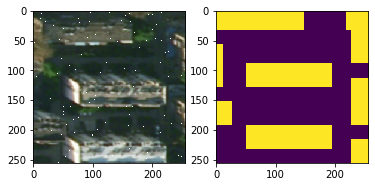

In [21]:
for i,m in data_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy()+1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

In [22]:
data_train = data_train.repeat().shuffle(24000).batch(BATCH_SIZE)
data_val = data_val.batch(BATCH_SIZE)

In [23]:
# 使用预训练网络
conv_base = tf.keras.applications.VGG16(weights="imagenet", # 使用该模型image权重
                                        input_shape=(256,256,3), 
                                        include_top = False)
layer_names = [
    "block5_conv3", # 14x14
    "block4_conv3", # 28x28
    "block3_conv3", # 56x56
    "block5_pool"
] # 获取输出层的名字
layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]
# 从预训练网络中创建子模型
multi_out_model = tf.keras.models.Model(inputs = conv_base.input,outputs = layers_output)
multi_out_model.trainable = False # 禁止训练

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [25]:
#构建模型
inputs = tf.keras.layers.Input(shape=(256,256,3))
out_block5_conv3,out_block4_conv3,out_block3_conv3,out = multi_out_model(inputs)
#输出512个卷积核 窗口大小3*3   图片变大2倍填充方式same保证和原有图像大小一样  激活relu
x1 = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding="same",activation="relu")(out) # 调用out层
x1 = tf.keras.layers.SpatialDropout2D(0.6)(x1)
x1 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x1) # 在增加一层卷积
x1 = tf.keras.layers.SpatialDropout2D(0.6)(x1)
x2 = tf.add(x1,out_block5_conv3) # 层相加
x2 = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding="same",activation="relu")(x2)
x2 = tf.keras.layers.SpatialDropout2D(0.6)(x2)
x2 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x2) # 在增加一层卷积
x2 = tf.keras.layers.SpatialDropout2D(0.6)(x2)
x3 = tf.add(x2,out_block4_conv3) # 层相加
x3 = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding="same",activation="relu")(x3)
x3 = tf.keras.layers.SpatialDropout2D(0.6)(x3)
x3 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x3) # 在增加一层卷积进一步提取特征
x3 = tf.keras.layers.SpatialDropout2D(0.6)(x3)
x4 = tf.add(x3,out_block3_conv3)
x5 = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding="same",activation="relu")(x4)
x5 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x5) # 在增加一层卷积进一步提取特征
prediction = tf.keras.layers.Conv2DTranspose(5, 3, strides=2,padding="same",activation="softmax")(x5) # 上采样
model = tf.keras.models.Model(inputs=inputs,outputs=prediction)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 16, 16, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 512)  2359808     model[1][3]                      
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 16, 16, 512)  0           conv2d_transpose[0][0]           
____________________________________________________________________________________________

In [27]:
# 编译模型
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"]
             )

In [28]:
# 导入保存的模型，第二次运行才可以进行的操作
# 给出模型保存的路径以及文件名
model_name = 'FCN'
#checkpoint_save_path = "./checkpoint/{0}-mineral-type{1}.ckpt".format(model_name,len(dirList)) 
checkpoint_save_path = "./model/{0}.ckpt".format(model_name) 
print('模型保存路径：',checkpoint_save_path)

# 读取模型
if os.path.exists(checkpoint_save_path + '.index'):        # 通过索引表判断保存文件是否存在
    print('-------------load the model-----------------')  # 是，则打印"导入模型"
    model.load_weights(checkpoint_save_path)               # 导入模型

模型保存路径： ./model/FCN.ckpt
-------------load the model-----------------


In [29]:
# 保存模型，第一次运行执行这一步操作
model_save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,  # 模型保存路径
                                                          monitor='acc',           # 监视值为 accuracy
                                                         save_weights_only=True,         # 只保留模型参数
                                                         save_best_only=True)            # 只保留最优结果

In [30]:
# 评价指标不在提升时，减少学习率. 当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=5, verbose=1, mode='auto')

In [31]:
# 当监测值不再改善时，该回调函数将中止训练
earlyStopping_callback = tf.keras.callbacks.EarlyStopping(
    # This callback will monitor the loss of the model
    monitor='loss',
    # Training will be interrupted when the accuracy
    # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
    patience=20,
    restore_best_weights = True  )# 是否从具有监测数量的最佳值的时期恢复模型权重。 如果为 False，则使用在训练的最后一步获得的模型权重。

In [32]:
# 训练
history = model.fit(data_train,
                    epochs=250,
                    verbose=1,
                    steps_per_epoch=step_per_epoch,
                    validation_steps=val_step,
                    validation_data=data_val,
                    shuffle=True,
                    callbacks=[model_save_callback, reduce_lr, earlyStopping_callback]
                   )

Epoch 1/250
750/750 [==============================] - 589s 786ms/step - loss: 0.9480 - acc: 0.6141 - val_loss: 0.8425 - val_acc: 0.6626 - lr: 0.0010
Epoch 2/250
750/750 [==============================] - 578s 771ms/step - loss: 0.8340 - acc: 0.6658 - val_loss: 0.7882 - val_acc: 0.6885 - lr: 0.0010
Epoch 3/250
750/750 [==============================] - 587s 783ms/step - loss: 0.7932 - acc: 0.6838 - val_loss: 0.7461 - val_acc: 0.7037 - lr: 0.0010
Epoch 4/250
750/750 [==============================] - 579s 772ms/step - loss: 0.7655 - acc: 0.6956 - val_loss: 0.7424 - val_acc: 0.7089 - lr: 0.0010
Epoch 5/250
750/750 [==============================] - 573s 763ms/step - loss: 0.7490 - acc: 0.7028 - val_loss: 0.7114 - val_acc: 0.7195 - lr: 0.0010
Epoch 6/250
750/750 [==============================] - 572s 763ms/step - loss: 0.7315 - acc: 0.7089 - val_loss: 0.7041 - val_acc: 0.7210 - lr: 0.0010
Epoch 7/250
750/750 [==============================] - 582s 776ms/step - loss: 0.7194 - acc: 0.7148 

750/750 [==============================] - 571s 762ms/step - loss: 0.4629 - acc: 0.8219 - val_loss: 0.5564 - val_acc: 0.7866 - lr: 0.0010
Epoch 110/250
750/750 [==============================] - 568s 757ms/step - loss: 0.4621 - acc: 0.8223 - val_loss: 0.5490 - val_acc: 0.7895 - lr: 0.0010
Epoch 111/250
750/750 [==============================] - 572s 763ms/step - loss: 0.4656 - acc: 0.8209 - val_loss: 0.5463 - val_acc: 0.7892 - lr: 0.0010
Epoch 112/250
750/750 [==============================] - 578s 771ms/step - loss: 0.4614 - acc: 0.8226 - val_loss: 0.5440 - val_acc: 0.7912 - lr: 0.0010
Epoch 113/250
750/750 [==============================] - 570s 759ms/step - loss: 0.4625 - acc: 0.8220 - val_loss: 0.5413 - val_acc: 0.7925 - lr: 0.0010
Epoch 114/250
750/750 [==============================] - 576s 768ms/step - loss: 0.4606 - acc: 0.8229 - val_loss: 0.5477 - val_acc: 0.7894 - lr: 0.0010
Epoch 115/250
750/750 [==============================] - 603s 804ms/step - loss: 0.4616 - acc: 0.8227 

Epoch 163/250
750/750 [==============================] - ETA: 0s - loss: 0.4323 - acc: 0.8344
Epoch 00163: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
750/750 [==============================] - 579s 772ms/step - loss: 0.4323 - acc: 0.8344 - val_loss: 0.5289 - val_acc: 0.7993 - lr: 0.0010
Epoch 164/250
750/750 [==============================] - 572s 763ms/step - loss: 0.4123 - acc: 0.8417 - val_loss: 0.5166 - val_acc: 0.8014 - lr: 1.0000e-04
Epoch 165/250
750/750 [==============================] - 576s 768ms/step - loss: 0.4041 - acc: 0.8445 - val_loss: 0.5172 - val_acc: 0.8012 - lr: 1.0000e-04
Epoch 166/250
750/750 [==============================] - 572s 763ms/step - loss: 0.4033 - acc: 0.8449 - val_loss: 0.5144 - val_acc: 0.8026 - lr: 1.0000e-04
Epoch 167/250
750/750 [==============================] - 566s 754ms/step - loss: 0.4026 - acc: 0.8449 - val_loss: 0.5195 - val_acc: 0.8007 - lr: 1.0000e-04
Epoch 168/250
750/750 [==============================] - 574s 7

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
# 保存训练的日志文件
pd.DataFrame(history.history).to_csv('training_log2.csv', index=False)

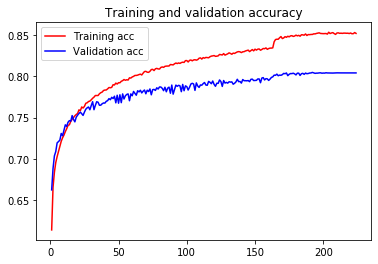

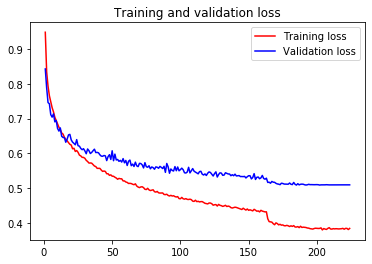

In [35]:
#  保存并绘制loss,acc
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("accuracy2.png", dpi = 300)
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("loss2.png", dpi = 300)
plt.show()

In [29]:
images_test=glob.glob('./dataset/split_train/test/images/*.png')
labels_test=glob.glob('./dataset/split_train/test/labels/*.png')

In [30]:
index = np.random.permutation(len(images_test))
images_test = np.array(images_test)[index] # 对训练集图片进行乱序
labels_test = np.array(labels_test)[index]

In [30]:
images_test[:5]

['./dataset/split_train/test/images\\10001.png',
 './dataset/split_train/test/images\\10040.png',
 './dataset/split_train/test/images\\10049.png',
 './dataset/split_train/test/images\\10054.png',
 './dataset/split_train/test/images\\10057.png']

In [31]:
labels_test[:5]

['./dataset/split_train/test/labels\\10001.png',
 './dataset/split_train/test/labels\\10040.png',
 './dataset/split_train/test/labels\\10049.png',
 './dataset/split_train/test/labels\\10054.png',
 './dataset/split_train/test/labels\\10057.png']

In [32]:
# 创建数据集
dataset1 = tf.data.Dataset.from_tensor_slices((images_test,labels_test))

In [33]:
dataset1 = dataset1.map(load_image,num_parallel_calls=auto)
dataset1 = dataset1.batch(BATCH_SIZE)

In [35]:
preds=model.evaluate(dataset1)#fcn

94/94 [==============================] - 29s 304ms/step - loss: 0.5032 - acc: 0.8073


In [ ]:
preds2=model1.evaluate(dataset1)#unet

In [ ]:
preds3=model2.evaluate(dataset1)#segnet

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
num=3

In [116]:
a=[]
for image, mask in dataset1.take(3): # 从test数据取出一个batch
    pred_mask = model.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
#     plt.figure(figsize=(10, 10))
#     for i in range(num):
#         plt.subplot(num, 3, i*num+1)
#         plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i])) # 原图
#         plt.savefig('acc1')
#         plt.subplot(num, 3, i*num+2)
#         plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i])) # 真实分割图
#         plt.subplot(num, 3, i*num+3)
#         plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i])) # 预测分割图
#         plt.savefig('acc1')

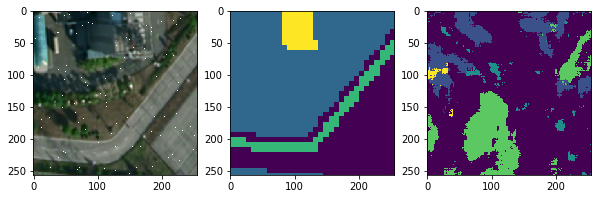

In [139]:
plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.imshow(tf.keras.preprocessing.image.array_to_img(image[21]))
plt.subplot(1,3,2)
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[21]))
plt.subplot(1,3,3)
plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[21]))
# plt.savefig('Fcn3-0')

In [128]:
for image, mask in dataset1.take(94):
    print(image.shape)
    print(mask.shape)

(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 256, 1)
(32, 256, 256, 3)
(32, 256, 

In [ ]:
for image, mask in dataset1.take(1): # 从test数据取出一个batch
    pred_mask = model1.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i])) # 原图
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i])) # 真实分割图
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i])) # 预测分割图
        plt.savefig('acc2')

In [ ]:
for image, mask in dataset1.take(1): # 从test数据取出一个batch
    pred_mask = model2.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i])) # 原图
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i])) # 真实分割图
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i])) # 预测分割图
        plt.savefig('ac3c')

In [35]:
import seaborn as sn
import pandas as pd

In [36]:
def fast_hist(a, b, n):
    #k为掩膜（去除了255这些点（即标签图中的白色的轮廓），其中的a>=0是为了防止bincount()函数出错）
    k = (a >= 0) & (a < n) 
    #bincount()函数用于统计数组内每个非负整数的个数
    #详见https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n**2).reshape(n, n) #核心代码

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)


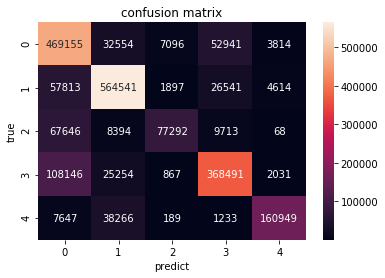

In [41]:
for image, mask in dataset1.take(1): # 从test数据取出一个batch
    pred_mask = model.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    print(pred_mask.shape)
    print(mask.shape)
    mask=np.array(mask).reshape(-1)
    pred_mask=np.array(pred_mask).reshape(-1)
    print(pred_mask.shape)
    print(mask.shape)
    a=fast_hist(mask,pred_mask,5)
    df_cm = pd.DataFrame(a)
    df_cm
    #annot = True 显示数字 ，fmt参数不使用科学计数法进行显示
    ax = sn.heatmap(df_cm,annot=True,fmt='.20g')
    ax.set_title('confusion matrix') #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    s1 = ax.get_figure()
    s1.savefig('混淆矩阵2.jpg',dpi=300,bbox_inches='tight')

In [39]:
c=pd.DataFrame({'0':[0,0,0,0,0],'1':[0,0,0,0,0],'2':[0,0,0,0,0],'3':[0,0,0,0,0],'4':[0,0,0,0,0]},index=[0,1,2,3,4])
for image, mask in dataset1.take(94): # 从test数据取出一个batch
    pred_mask = model.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    print(pred_mask.shape)
    print(mask.shape)
    mask=np.array(mask).reshape(-1)
    pred_mask=np.array(pred_mask).reshape(-1)
    print(pred_mask.shape)
    print(mask.shape)
    a=fast_hist(mask,pred_mask,5)
    df_cm = pd.DataFrame(a)
    c=pd.concat([c,df_cm])
    print(c)

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
     0    1    2    3    4         0         1        2         3        4
0  0.0  0.0  0.0  0.0  0.0       NaN       NaN      NaN       NaN      NaN
1  0.0  0.0  0.0  0.0  0.0       NaN       NaN      NaN       NaN      NaN
2  0.0  0.0  0.0  0.0  0.0       NaN       NaN      NaN       NaN      NaN
3  0.0  0.0  0.0  0.0  0.0       NaN       NaN      NaN       NaN      NaN
4  0.0  0.0  0.0  0.0  0.0       NaN       NaN      NaN       NaN      NaN
0  NaN  NaN  NaN  NaN  NaN  391692.0   16902.0   9078.0   41878.0    766.0
1  NaN  NaN  NaN  NaN  NaN   69851.0  893562.0   1463.0   24059.0   4632.0
2  NaN  NaN  NaN  NaN  NaN   46501.0    8041.0  46953.0    2594.0    296.0
3  NaN  NaN  NaN  NaN  NaN   79596.0   39914.0    593.0  303075.0   1608.0
4  NaN  NaN  NaN  NaN  NaN    8989.0   23242.0    129.0    2605.0  79133.0
(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1        2         3         4    0    

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1        2         3         4    0    1    2    3    4
0       NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
0  391692.0   16902.0   9078.0   41878.0     766.0  NaN  NaN  NaN  NaN  NaN
1   69851.0  893562.0   1463.0   24059.0    4632.0  NaN  NaN  NaN  NaN  NaN
2   46501.0    8041.0  46953.0    2594.0     296.0  NaN  NaN  NaN  NaN  NaN
3   79596.0   39914.0    593.0  303075.0    1608.0  NaN  NaN  NaN  NaN  NaN
4    8989.0   23242.0    129.0    2605.0   79133.0  NaN  NaN  NaN  NaN  NaN
0  317677.0   15778.0   7443.0   34105.0    1271.0  NaN  NaN  NaN  NaN  NaN
1   55408.0  907669.0   2149.0

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1         2         3         4    0    1    2    3    4
0       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
0  391692.0   16902.0    9078.0   41878.0     766.0  NaN  NaN  NaN  NaN  NaN
1   69851.0  893562.0    1463.0   24059.0    4632.0  NaN  NaN  NaN  NaN  NaN
2   46501.0    8041.0   46953.0    2594.0     296.0  NaN  NaN  NaN  NaN  NaN
3   79596.0   39914.0     593.0  303075.0    1608.0  NaN  NaN  NaN  NaN  NaN
4    8989.0   23242.0     129.0    2605.0   79133.0  NaN  NaN  NaN  NaN  NaN
0  317677.0   15778.0    7443.0   34105.0    1271.0  NaN  NaN  NaN  NaN  NaN
1   55408.0  90766

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
          0         1         2         3         4    0    1    2    3    4
0       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
0  391692.0   16902.0    9078.0   41878.0     766.0  NaN  NaN  NaN  NaN  NaN
1   69851.0  893562.0    1463.0   24059.0    4632.0  NaN  NaN  NaN  NaN  NaN
2   46501.0    8041.0   46953.0    2594.0     296.0  NaN  NaN  NaN  NaN  NaN
3   79596.0   39914.0     593.0  303075.0    1608.0  NaN  NaN  NaN  NaN  NaN
4    8989.0   23242.0     129.0    2605.0   79133.0  NaN  NaN  NaN  NaN  NaN
0  317677.0   15778.0    7443.0   34105.0    1271.0  NaN  NaN  NaN  NaN  NaN
1   55408.0  90766

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3        4    0    1    2    3    4
0        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...      ...  ...  ...  ...  ...  ...
0   530769.0   18996.0    8284.0   68069.0    886.0  NaN  NaN  NaN  NaN  NaN
1    54732.0  512126.0    1787.0   27312.0   3993.0  NaN  NaN  NaN  NaN  NaN
2    58841.0    5838.0  170199.0    8029.0     10.0  NaN  NaN  NaN  NaN  NaN
3   112363.0   14698.0    4887.0  395236.0     42.0  NaN  NaN  NaN  NaN  NaN
4     7727.0    9676.0     128.0     911.0  81613.0  NaN  NaN  NaN  NaN  NaN

[85 rows x 10 col

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   587856.0   31075.0   8227.0   76074.0    5628.0  NaN  NaN  NaN  NaN  NaN
1    28054.0  483460.0   1420.0    6138.0    2928.0  NaN  NaN  NaN  NaN  NaN
2    57922.0    5025.0  57554.0    6318.0      76.0  NaN  NaN  NaN  NaN  NaN
3   180451.0   14875.0   1183.0  383836.0     674.0  NaN  NaN  NaN  NaN  NaN
4     5504.0   10088.0     48.0    1169.0  141569.0  NaN  NaN  NaN  NaN  NaN

[130 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3        4    0    1    2    3    4
0        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...      ...  ...  ...  ...  ...  ...
0   528530.0   15120.0   12434.0   73835.0   1330.0  NaN  NaN  NaN  NaN  NaN
1    17945.0  783659.0    1111.0    5260.0   4095.0  NaN  NaN  NaN  NaN  NaN
2    39717.0    1915.0  101840.0    1821.0      3.0  NaN  NaN  NaN  NaN  NaN
3    94804.0    3924.0     969.0  298310.0    237.0  NaN  NaN  NaN  NaN  NaN
4     1623.0   10871.0       3.0     330.0  97466.0  NaN  NaN  NaN  NaN  NaN

[175 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   578294.0   33106.0   9193.0   76541.0    4173.0  NaN  NaN  NaN  NaN  NaN
1    46385.0  752214.0   2140.0   11220.0    1863.0  NaN  NaN  NaN  NaN  NaN
2    27703.0    4068.0  38356.0    1617.0      47.0  NaN  NaN  NaN  NaN  NaN
3    82202.0    4792.0    453.0  280537.0       2.0  NaN  NaN  NaN  NaN  NaN
4     6582.0   31264.0     79.0     752.0  103569.0  NaN  NaN  NaN  NaN  NaN

[220 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   550379.0   32273.0   8124.0   83826.0    1565.0  NaN  NaN  NaN  NaN  NaN
1    22942.0  432908.0    443.0   19292.0    2177.0  NaN  NaN  NaN  NaN  NaN
2    28615.0    1662.0  17214.0    1972.0      10.0  NaN  NaN  NaN  NaN  NaN
3   221299.0   46592.0   4669.0  462803.0    2327.0  NaN  NaN  NaN  NaN  NaN
4     5605.0   16991.0     59.0    1090.0  132315.0  NaN  NaN  NaN  NaN  NaN

[265 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1         2         3        4    0    1    2    3    4
0        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...      ...  ...  ...  ...  ...  ...
0   507952.0   28048.0    9960.0   53994.0    609.0  NaN  NaN  NaN  NaN  NaN
1    54202.0  699925.0    2281.0   10487.0   3287.0  NaN  NaN  NaN  NaN  NaN
2    67018.0    4358.0  161596.0    4583.0     11.0  NaN  NaN  NaN  NaN  NaN
3   113958.0    7890.0     477.0  261602.0    413.0  NaN  NaN  NaN  NaN  NaN
4     8806.0   27767.0     148.0    2553.0  65227.0  NaN  NaN  NaN  NaN  NaN

[310 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   576043.0   31077.0   9265.0   75563.0   2129.0  NaN  NaN  NaN  NaN  NaN
1    16238.0  645712.0    676.0    7719.0   2109.0  NaN  NaN  NaN  NaN  NaN
2    32106.0   11632.0  21078.0    4154.0    288.0  NaN  NaN  NaN  NaN  NaN
3    93859.0   17599.0    356.0  431157.0    287.0  NaN  NaN  NaN  NaN  NaN
4     5171.0   14671.0      7.0    7824.0  90432.0  NaN  NaN  NaN  NaN  NaN

[355 rows x 10 columns]
(32, 

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   502425.0   39356.0   9323.0   62564.0    5534.0  NaN  NaN  NaN  NaN  NaN
1    64322.0  637922.0   2382.0   20939.0    9284.0  NaN  NaN  NaN  NaN  NaN
2    35593.0    8643.0  97286.0    1958.0      26.0  NaN  NaN  NaN  NaN  NaN
3    74544.0   10470.0    791.0  268022.0     301.0  NaN  NaN  NaN  NaN  NaN
4     7137.0   52876.0    193.0     729.0  184532.0  NaN  NaN  NaN  NaN  NaN

[400 rows x 10 co

(32, 256, 256, 1)
(32, 256, 256, 1)
(2097152,)
(2097152,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   639423.0   35510.0  12998.0   65634.0    4858.0  NaN  NaN  NaN  NaN  NaN
1    54541.0  472028.0   1215.0   15219.0    3942.0  NaN  NaN  NaN  NaN  NaN
2    39098.0     306.0  78025.0    2250.0       0.0  NaN  NaN  NaN  NaN  NaN
3   120263.0   16214.0   2118.0  393773.0    2523.0  NaN  NaN  NaN  NaN  NaN
4     4978.0   11369.0    230.0     315.0  120322.0  NaN  NaN  NaN  NaN  NaN

[445 rows x 10 co

In [41]:
c.groupby(c.index).sum().reset_index()

,index,0,1,2,3,4,0,1,2,3,4
0,0,48970897.0,2864430.0,956155.0,6496684.0,225803.0,0.0,0.0,0.0,0.0,0.0
1,1,4585381.0,57005400.0,197178.0,1481172.0,416886.0,0.0,0.0,0.0,0.0,0.0
2,2,4588240.0,587776.0,7081144.0,335247.0,18333.0,0.0,0.0,0.0,0.0,0.0
3,3,10960944.0,1343459.0,123737.0,34922978.0,88739.0,0.0,0.0,0.0,0.0,0.0
4,4,662514.0,1771836.0,18525.0,156888.0,10747654.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for image, mask in dataset1.take(1): # 从test数据取出一个batch
    pred_mask = model1.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    print(pred_mask.shape)
    print(mask.shape)
    mask=np.array(mask).reshape(-1)
    pred_mask=np.array(pred_mask).reshape(-1)
    print(pred_mask.shape)
    print(mask.shape)
    b=fast_hist(mask,pred_mask,5)
    df_cm = pd.DataFrame(b)
    df_cm
    #annot = True 显示数字 ，fmt参数不使用科学计数法进行显示
    ax = sn.heatmap(df_cm,annot=True,fmt='.20g')
    ax.set_title('confusion matrix') #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    s1 = ax.get_figure()
    s1.savefig('混淆矩阵3.jpg',dpi=300,bbox_inches='tight')

In [ ]:
for image, mask in dataset1.take(1): # 从test数据取出一个batch
    pred_mask = model2.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    print(pred_mask.shape)
    print(mask.shape)
    mask=np.array(mask).reshape(-1)
    pred_mask=np.array(pred_mask).reshape(-1)
    print(pred_mask.shape)
    print(mask.shape)
    c=fast_hist(mask,pred_mask,5)
    df_cm = pd.DataFrame(c)
    df_cm
    #annot = True 显示数字 ，fmt参数不使用科学计数法进行显示
    ax = sn.heatmap(df_cm,annot=True,fmt='.20g')
    ax.set_title('confusion matrix') #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    s1 = ax.get_figure()
    s1.savefig('混淆矩阵4.jpg',dpi=300,bbox_inches='tight')

In [ ]:
#类别像素准确率CPA
classAcca = np.diag(a) / a.sum(axis=1)
classAccb = np.diag(b) / b.sum(axis=1)
classAccc = np.diag(c) / c.sum(axis=1)
print(classAcca)#fcn
print(classAccb)#unet
print(classAccc)#segnet

In [ ]:
#类别平均像素精度
meanAcca = np.nanmean(classAcca) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
meanAccb = np.nanmean(classAccb) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
meanAccc = np.nanmean(classAccc) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
print(meanAcca)
print(meanAccb)
print(meanAccc)

In [ ]:
#MIoU：平均交并比
intersectiona = np.diag(a) # 取对角元素的值，返回列表
uniona = np.sum(a, axis=1) + np.sum(a, axis=0) - np.diag(a) # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
IoUa = intersectiona / uniona  # 返回列表，其值为各个类别的IoU
mIoUa = np.nanmean(IoUa)
print(IoUa)
print(mIoUa)
intersectionb = np.diag(b) # 取对角元素的值，返回列表
unionb = np.sum(b, axis=1) + np.sum(b, axis=0) - np.diag(b) # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
IoUb = intersectionb / unionb  # 返回列表，其值为各个类别的IoU
mIoUb = np.nanmean(IoUb)
print(IoUb)
print(mIoUb)
intersectionc = np.diag(c) # 取对角元素的值，返回列表
unionc = np.sum(c, axis=1) + np.sum(c, axis=0) - np.diag(c) # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
IoUc = intersectionc / unionc  # 返回列表，其值为各个类别的IoU
mIoUc = np.nanmean(IoUc)
print(IoUc)
print(mIoUc)

In [ ]:
#FWIOU
freqa = np.sum(a, axis=1) / np.sum(a)
iua = np.diag(a) / (np.sum(a, axis=1) + np.sum(a, axis=0) -np.diag(a))
FWIoUa = (freqa[freqa > 0] * iua[freqa > 0]).sum()
print(FWIoUa)
freqb = np.sum(b, axis=1) / np.sum(b)
iub = np.diag(b) / (np.sum(b, axis=1) + np.sum(b, axis=0) -np.diag(b))
FWIoUb = (freqb[freqb > 0] * iub[freqb > 0]).sum()
print(FWIoUb)
freqc = np.sum(c, axis=1) / np.sum(c)
iuc = np.diag(c) / (np.sum(c, axis=1) + np.sum(c, axis=0) -np.diag(c))
FWIoUc = (freqc[freqc > 0] * iuc[freqc > 0]).sum()
print(FWIoUc)

In [ ]:
def kappa_cal(matrix):
    n = np.sum(matrix)
    sum_po = 0
    sum_pe = 0
    for i in range(len(matrix[0])):
        sum_po += matrix[i][i]
        row = np.sum(matrix[i, :])
        col = np.sum(matrix[:, i])
        sum_pe += row * col
    po = sum_po / n
    pe = sum_pe / (n * n)
    # print(po, pe)
    return (po - pe) / (1 - pe)

In [ ]:
kappa_a=kappa_cal(a)
kappa_b=kappa_cal(b)
kappa_c=kappa_cal(c)
print(kappa_a)
print(kappa_b)
print(kappa_c)